<a href="https://colab.research.google.com/github/Skezzowski/CPT-Calculator/blob/master/A_s%C3%ADpol%C3%B3%2C_terhes_n%C5%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,OneHotEncoder,PolynomialFeatures
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import graphviz
import numpy as np
from datetime import datetime

%tensorflow_version 1.x
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras.utils import to_categorical
from keras import metrics
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import seaborn as sns

TensorFlow 1.x selected.


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data import and preprocess

In [ ]:
from google.colab import files
# Pacgake Installs and dataset load
!pip install -q kaggle

import os
os.environ['KAGGLE_USERNAME'] = "skezzowski" # username from the json file
os.environ['KAGGLE_KEY'] = "6f64abfd5a187ead9dd72d32f19db2cb" # key from the json file

!kaggle datasets download -d jsphyg/weather-dataset-rattle-package
data_all = pd.read_csv('weather-dataset-rattle-package.zip', compression='zip', header=0, sep=',', quotechar='"')
data_all["Date"]=list(datetime.timestamp(datetime.strptime(x,"%Y-%m-%d")) for x in data_all["Date"].values)
data_all['RainTomorrow']=data_all['RainTomorrow'].replace(('Yes', 'No'), (1, 0),inplace=False)
len(data_all['Location'].value_counts().index)

  0% 0.00/3.87M [00:00<?, ?B/s]
100% 3.87M/3.87M [00:00<00:00, 128MB/s]


49

In [ ]:
continousFeatures = ['Rainfall', 'MinTemp', 'MaxTemp', 'Humidity3pm','Humidity9am','WindSpeed3pm','WindSpeed9am', 'Temp9am', 'Temp3pm', 'Pressure3pm','Pressure9am']
catergoryFeatures = ['Location','WindDir9am','WindGustDir']
uselessColumns = ['Sunshine','Evaporation', 'Date', 'Cloud9am', 'Cloud3pm', 'RainToday', 'WindGustSpeed']

def getData(continousFeatures, catergoryFeatures, uselessColumns, dropNa = False, dropCategorys = True):
  standardScaler = StandardScaler()

  preprocessedData = pd.DataFrame(data_all)
  preprocessedData = preprocessedData.drop(labels=uselessColumns, axis= 1) # Dropped because these are mostly NaN columns and Date seems unnecessery, RainToday helyett ott van a Rainfall

  if dropNa :
    preprocessedData = preprocessedData.dropna()
  else:
    preprocessedData[continousFeatures] = preprocessedData[continousFeatures].fillna(preprocessedData[continousFeatures].mean(), inplace=False) #NaN-ok eltűntetése meannel
    #preprocessedData= preprocessedData.interpolate( method='time', axis=0, limit=None, inplace=False, limit_direction='both', limit_area=None, downcast=None)

  if dropCategorys:
    preprocessedData = preprocessedData.drop(labels=catergoryFeatures, axis= 1) 
  else:
    for x in catergoryFeatures:
      preprocessedData[x] = preprocessedData[x].astype('category').cat.codes
    preprocessedData[catergoryFeatures] = standardScaler.fit_transform(preprocessedData[catergoryFeatures])

  if continousFeatures:
    preprocessedData[continousFeatures] = standardScaler.fit_transform(preprocessedData[continousFeatures])
    
  #preprocessedData = pd.get_dummies(preprocessedData, columns=catergoryFeatures, prefix=catergoryFeatures, dummy_na=True) # OneHot encodolás az összes kategorikus jellemzőre, hatalmas lesz így a táblázat

  x = preprocessedData.drop(labels=['RISK_MM', 'RainTomorrow'], axis=1)
  y = preprocessedData.loc[:,'RainTomorrow']
  return x, y

def getDataForTest(neededContinuesColumns, dropNa):
  standardScaler = StandardScaler()
  neededContinuesColumns.append('RainTomorrow')
  preprocessedData = data_all.loc[:,neededContinuesColumns]
  neededContinuesColumns.remove('RainTomorrow')
  y= []

  if dropNa:
    preprocessedData = preprocessedData.dropna()
  else:
    preprocessedData[neededContinuesColumns] = preprocessedData[neededContinuesColumns].fillna(preprocessedData[neededContinuesColumns].mean(), inplace=False)
  
  y = preprocessedData.loc[:,'RainTomorrow']
  preprocessedData[neededContinuesColumns] = standardScaler.fit_transform(preprocessedData[neededContinuesColumns])

  x = preprocessedData.drop(labels=['RainTomorrow'],axis=1)
  return x, y


rainyDays = data_all[data_all['RainTomorrow']==1]
notRainyDays =data_all[data_all['RainTomorrow']==0]

print(rainyDays.shape)
print(notRainyDays.shape)
print(data_all.shape)

(31877, 24)
(110316, 24)
(142193, 24)


#Adat vizualizáció

In [ ]:
x


,Rainfall,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
5939,-0.265286,1.215741,0.523725,-1.164419,0.020191,-2.471479,-1.809395,-1.580595,-1.512923,-0.800666,0.253249,1.282705,1.565503
5940,-0.265286,1.401611,-0.299112,0.396283,-0.097288,-1.933293,-2.056402,-0.625431,-0.391017,-1.157137,-1.253940,0.318673,0.626699
5942,-0.265286,0.764344,0.374118,1.716878,-0.567202,-1.287470,-1.364782,-0.712264,-0.813553,-1.157137,0.630047,1.604049,1.785535
5943,-0.265286,1.189189,-0.747932,-1.164419,-1.624510,-1.556563,-1.364782,-0.654375,-0.828123,-1.157137,0.253249,1.665257,1.888217
5944,-0.265286,0.180182,-0.448719,0.156175,-0.802159,-2.525297,-1.710592,-0.943819,-1.075817,-1.157137,0.630047,2.353851,2.181593
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139108,-0.265286,0.870555,-0.448719,-0.804257,0.020191,-0.157280,-0.870768,-0.480709,-0.624140,-1.513608,-1.253940,0.961361,1.404146
139109,-0.265286,0.233288,-0.299112,-0.324041,-1.037117,-0.534010,-1.068374,-0.379403,-0.522149,0.981690,-1.630738,1.007267,1.360139
139110,-0.265286,0.870555,-0.598325,0.156175,-1.037117,-1.072196,-1.315381,-0.278098,-0.434728,-1.513608,-1.630738,1.007267,1.374808
139111,-0.265286,0.764344,-1.121949,-0.804257,-0.332245,-0.211099,0.413670,-0.335987,-0.595000,-1.157137,-1.253940,1.007267,0.949413


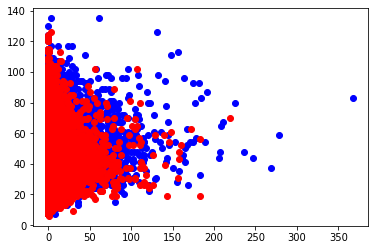

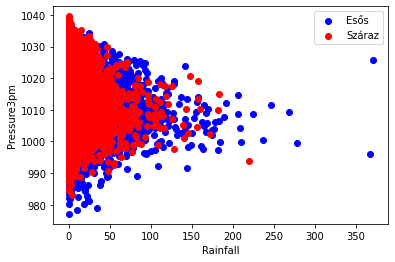

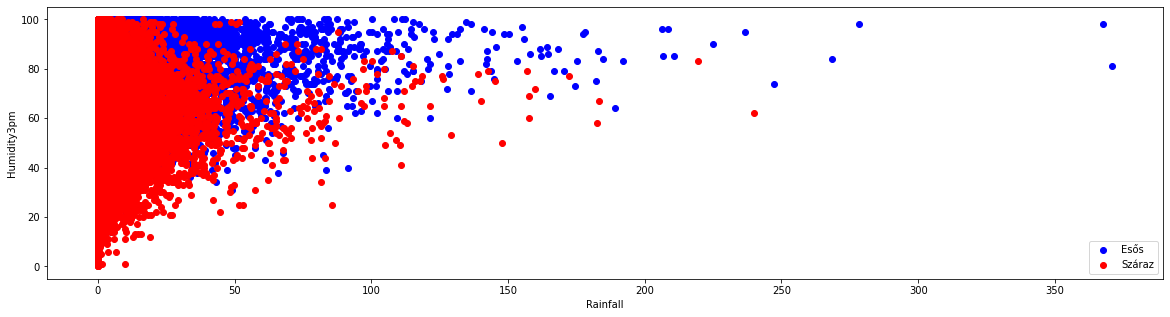

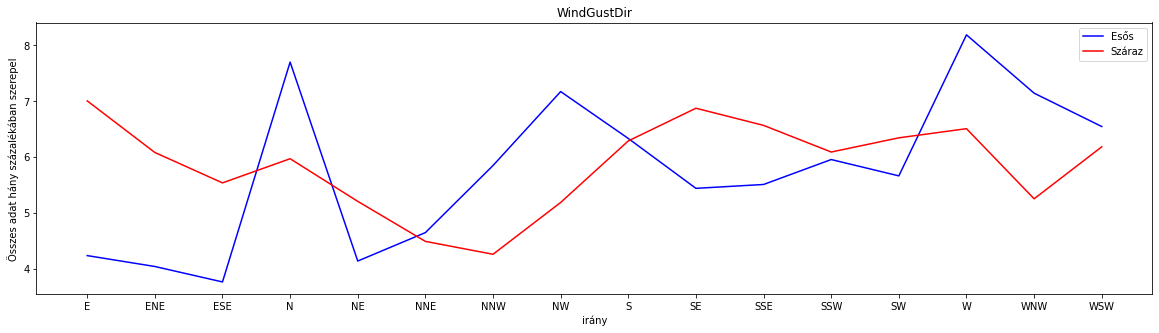

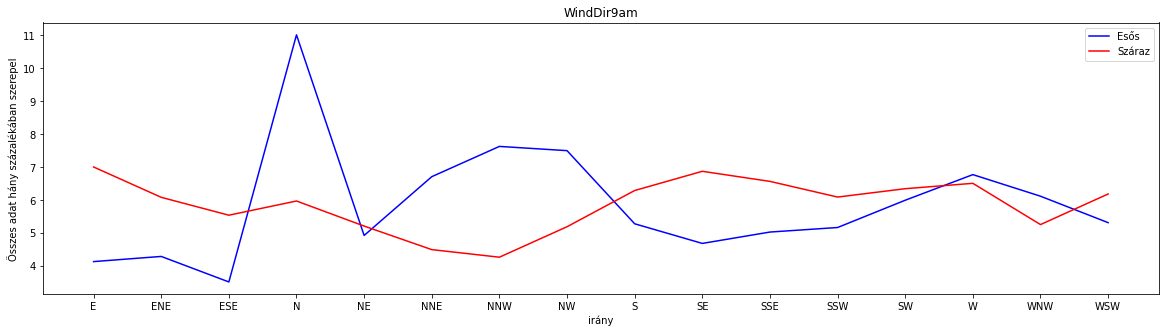

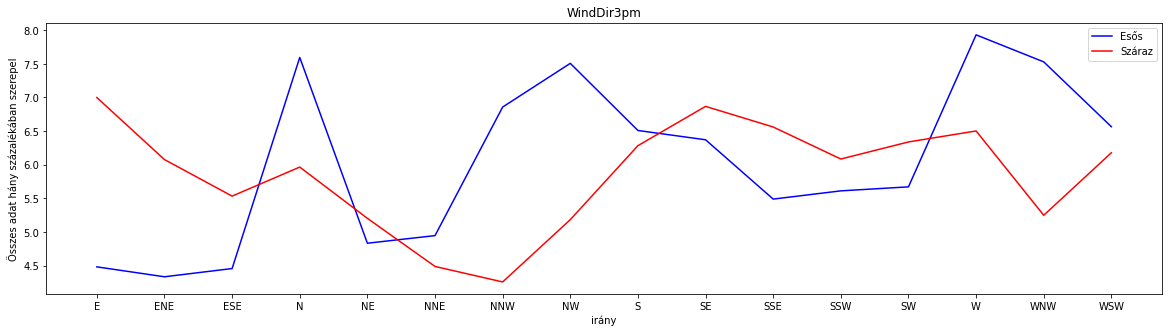

In [ ]:
def makeWindPlot(rainy, notrainy, title=""):
  rainy = rainy.sort_index()
  notrainy = notrainy.sort_index()

  plt.figure(figsize=(20,5))
  pointsR = rainy.index
  frequencyR = rainy.values*100
  pointsNR = notrainy.index
  frequencyNR = notrainy.values*100

  plt.title(title)
  plt.plot(pointsR,frequencyR, color="blue", label="Esős")
  plt.plot(pointsNR,frequencyNR, color="red", label="Száraz")
  plt.title(title) 
  plt.xlabel('irány') 
  plt.ylabel('Összes adat hány százalékában szerepel')
  plt.legend()
  plt.show()

plt.scatter(rainyDays['Rainfall'],rainyDays['WindGustSpeed'] ,color='blue', label='Esős')
plt.scatter(notRainyDays['Rainfall'],notRainyDays['WindGustSpeed']  , color='red',label='Száraz')
plt.show()

plt.scatter(rainyDays['Rainfall'],rainyDays['Pressure3pm'],color='blue', label='Esős')
plt.scatter(notRainyDays['Rainfall'],notRainyDays['Pressure3pm'], color='red',label='Száraz')
plt.xlabel('Rainfall') 
plt.ylabel('Pressure3pm')
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
plt.scatter(rainyDays['Rainfall'],rainyDays['Humidity3pm']  ,color='blue', label='Esős')
plt.scatter(notRainyDays['Rainfall'], notRainyDays['Humidity3pm']  , color='red',label='Száraz')
plt.xlabel('Rainfall') 
plt.ylabel('Humidity3pm')
plt.legend()
plt.show()

makeWindPlot(rainyDays["WindGustDir"].value_counts()/len(rainyDays), notRainyDays["WindGustDir"].value_counts()/len(notRainyDays), "WindGustDir")
makeWindPlot(rainyDays["WindDir9am"].value_counts()/len(rainyDays), notRainyDays["WindGustDir"].value_counts()/len(notRainyDays), "WindDir9am")
makeWindPlot(rainyDays["WindDir3pm"].value_counts()/len(rainyDays), notRainyDays["WindGustDir"].value_counts()/len(notRainyDays),"WindDir3pm")

In [ ]:
sns.pairplot(data_all,vars=['Humidity3pm', 'Humidity9am', 'Pressure9am','Pressure3pm'],hue='RainTomorrow',palette='Dark2')

In [ ]:
sns.pairplot(data_all,vars=['Sunshine', 'Evaporation'],hue='RainTomorrow',palette='Dark2')

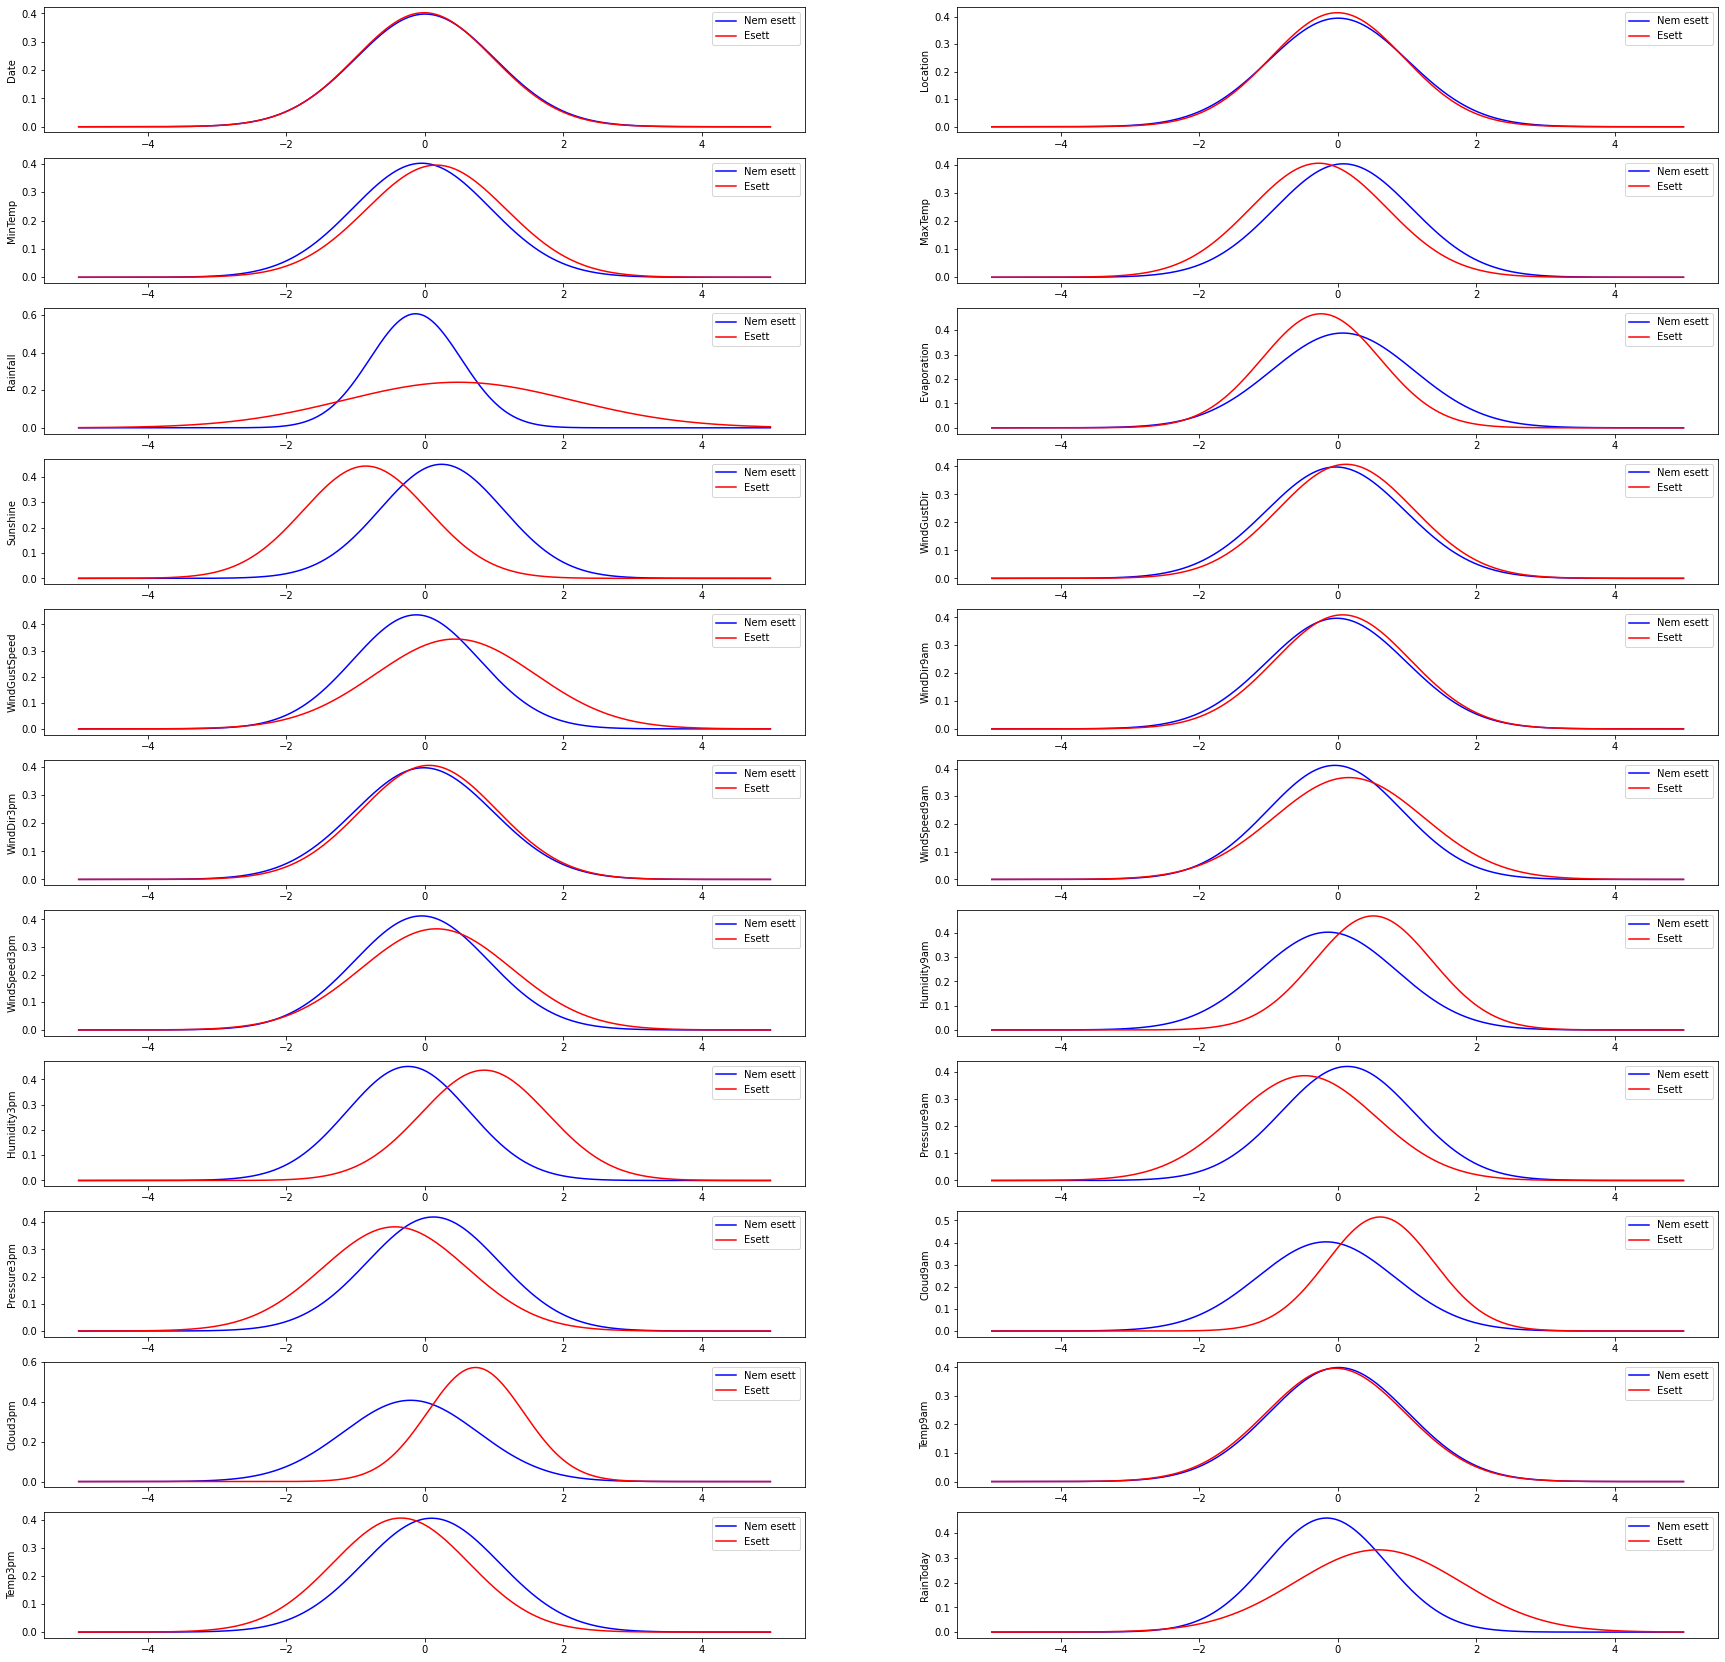

In [ ]:
def normal_distribution(x, m, ss):
    return (1 / np.sqrt(2 * np.pi * ss)) * np.exp(-np.square(x - m) / (2 * ss))

def plot_normal_dist(x, params, s, ylabel, diag):
    for (m, ss) in params:
        diag.plot(x, normal_distribution(x, m, ss), s[1], label=s[0])
    
    diag.set_ylabel(ylabel)
    diag.legend()

continousFeatures = ['Rainfall', 'MinTemp', 'MaxTemp', 'Humidity3pm', 'Humidity9am','WindSpeed3pm', 'WindSpeed9am', 'Temp9am', 'Temp3pm',
                     'Pressure3pm', 'Pressure9am', 'Sunshine', 'Evaporation', 'Date', 'Cloud9am', 'Cloud3pm',  'WindGustSpeed']
catergoryFeatures = ['RainToday', 'Location', 'WindDir9am', 'WindDir3pm', 'WindGustDir' ]
uselessColumns = []

x, y = getData(continousFeatures, catergoryFeatures, uselessColumns, True, False)
xv = x.to_numpy(copy=True)
yv = y.to_numpy(copy=True)
model = GaussianNB()
model.fit(xv, yv)

labels = [('Nem esett', 'b'), ('Esett', 'r')]
plt.rcParams['font.size'] = 10
f, diag = plt.subplots(int(x.columns.shape[0] / 2 ), 2)
f.set_figheight(30)
f.set_figwidth(30)
for j in range(x.columns.shape[0]):
  for i, s in enumerate(labels):
    plot_normal_dist(np.arange(-5, +5, 0.01), [(model.theta_[i, j], model.sigma_[i,j])], s, x.columns[j], diag[int(j / 2), j % 2])

#Baseline
Leggyakoribb címke választása, majdnem 80%-os pontosság

In [ ]:
# BASE_LINE

continousFeatures = ['Rainfall', 'Humidity3pm', 'Humidity9am', 'WindSpeed3pm', 'WindSpeed9am','Temp9am',
                     'Temp3pm', 'Pressure3pm', 'Pressure9am', 'WindGustSpeed']
catergoryFeatures = ['Location','WindDir9am', 'WindDir3pm','WindGustDir']
uselessColumns = ['RainToday','Date','Sunshine','Evaporation', 'Cloud9am','MinTemp','MaxTemp','Cloud3pm']
x, y = getData(continousFeatures, catergoryFeatures, uselessColumns, dropNa=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

base_line = DummyClassifier(strategy='most_frequent')
base_line.fit(x_train,y_train)

p_test = base_line.predict(x_test)

base_line_acc = accuracy_score(y_test,p_test)
print('baseline-acc: ',base_line_acc) # ~ 80%

#Neuronháló


In [ ]:
continousFeatures = ['Rainfall', 'Humidity3pm','Humidity9am','WindSpeed3pm','WindSpeed9am',
                     'Temp9am', 'Temp3pm', 'Pressure3pm','Pressure9am','WindGustSpeed', 'Cloud9am', 'Cloud3pm','Sunshine']
catergoryFeatures = ['Location','WindDir9am', 'WindDir3pm','WindGustDir']
uselessColumns = ['RainToday','Date','Evaporation','MinTemp', 'MaxTemp' ]
x, y = getData(continousFeatures, catergoryFeatures, uselessColumns, dropNa=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

y_test_neuro = to_categorical(y_test)
y_train_neuro = to_categorical(y_train)

epochs = 50
batch_size = 256
num_classes = 2

model = Sequential()
model.add(Dense(x_train.shape[1]+1, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)


history = model.fit(x_train, y_train_neuro,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=False,
                    validation_split=0.1,
                    callbacks=[early_stopping])
score = model.evaluate(x_test, y_test_neuro, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 14)                196       
_________________________________________________________________
dropout_79 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 200)               3000      
_________________________________________________________________
dropout_80 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_81 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 2)               

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail())


def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss and val_loss')
    plt.plot(hist['epoch'], hist['loss'], label='loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='val_loss')
    plt.legend()
    plt.ylim([(min(hist['loss'].min(), hist['val_loss'].min())) * 0.9,
              (max(hist['loss'].max(), hist['val_loss'].max())) * 1.1])
    # Ha ki szeretnénk menteni az ábrát:
    #plt.savefig(newpath + r'/loss_val_loss_%d.png' % se)

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
             label='Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
             label='Validation Accuracy')
    plt.legend()
    plt.ylim([(min(hist['accuracy'].min(), hist['val_accuracy'].min())) * 0.9,
              (max(hist['accuracy'].max(), hist['val_accuracy'].max())) * 1.1])
    #plt.savefig(newpath + r'/accuracy_val_accuracy_%d.png' % se)


plot_history(history)


#Decision Tree Classifier

In [ ]:
continousFeatures = ['Rainfall', 'Humidity3pm', 'Humidity9am', 'WindSpeed3pm', 'WindSpeed9am','Temp9am',
                     'Temp3pm', 'Pressure3pm', 'Pressure9am', 'WindGustSpeed','Sunshine','Cloud9am', 'Cloud3pm']
catergoryFeatures = ['Location','WindDir9am', 'WindDir3pm','WindGustDir']
uselessColumns = ['RainToday','MinTemp','Date','MaxTemp','Evaporation']
x, y = getData(continousFeatures, catergoryFeatures, uselessColumns, dropNa=False)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)


poly = PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)

#x_train = poly.fit_transform(x_train)
#x_test = poly.fit_transform(x_test)

params = [{'max_depth':[4,5,6,7,8,9,10],'min_samples_leaf':[1,2,3,4,5],'criterion' : ["gini", "entropy"]}]
clf = GridSearchCV(estimator=tree.DecisionTreeClassifier(),param_grid=params,scoring='accuracy',cv=10,return_train_score=True)

clf.fit(x_train,y_train)
print('Best-params:',clf.best_params_)
print('Best-score:',clf.best_score_)
print(clf.cv_results_.keys())

Best-params: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 4}
Best-score: 0.83180370550687
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_min_samples_leaf', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])


In [ ]:
clf.score(x_test,y_test)

0.858644818734836

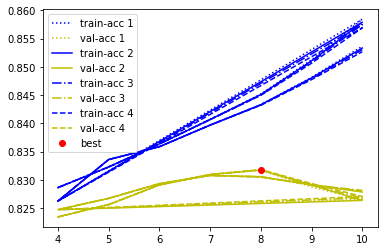

In [ ]:
df = pd.DataFrame(clf.cv_results_)

f = plt.figure()
line_styles = [':','-','-.','--']
for ms,ls in zip(df['param_min_samples_leaf'].unique(),line_styles):
  subd_df = df[df['param_min_samples_leaf']==ms]
  depth = subd_df['param_max_depth']
  train_means = subd_df['mean_train_score'].values
  val_means = subd_df['mean_test_score'].values
  plt.plot(depth,train_means,'b'+ls,label='train-acc '+str(ms))
  plt.plot(depth,val_means,'y'+ls,label='val-acc '+str(ms))
plt.plot(clf.best_params_['max_depth'],clf.best_score_,'ro',label='best')
plt.legend()

In [ ]:
clf  = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf=3, max_features='auto')
clf.fit(x_train_transformed, y_train)

print("train acc:",clf.score(x_train_transformed,y_train))
print("test acc:",clf.score(x_test_transformed,y_test))

#Support Vector Machine


In [ ]:
test5 = ([ 'Rainfall', 'Humidity3pm', 'Humidity9am', 'WindSpeed3pm', 'WindSpeed9am', 'Temp9am', 'Temp3pm', 'Pressure3pm',
          'Pressure9am', 'WindGustSpeed', 'Cloud9am', 'Cloud3pm', 'Sunshine'],True)
x, y = getDataForTest(test5[0],test5[1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
 
param_grid = {'C': [0.1,0.5, 0.8, 1], 'gamma': [0.1,0.01,'scale','auto'], }
gridS = GridSearchCV(estimator=SVC(kernel='linear'),param_grid=param_grid,scoring='accuracy',cv=10,return_train_score=True,refit=True,verbose=2, n_jobs=-1)

gridS.fit(x_train[:10000],y_train[:10000])
print('Best-params:',gridS.best_params_)
print('Best-score:',gridS.best_score_)
print(gridS.cv_results_.keys())


#model = SVC(C=.3,kernel='rbf',gamma='scale')
#model.fit(x_train,y_train)
#model.score(x_test,y_test)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  5.7min finished


Best-params: {'C': 0.1, 'gamma': 0.1}
Best-score: 0.8356
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])


In [ ]:
gridS.score(x_test, y_test)

0.8634735526863807

# KNN algoritmus

In [ ]:
import timeit
import sys

needed = [ 'Rainfall', 'MinTemp', 'MaxTemp', 'Humidity3pm', 'Humidity9am', 'WindSpeed3pm', 'WindSpeed9am', 'Temp9am', 'Temp3pm', 'Pressure3pm', 'Pressure9am', 'WindGustSpeed', 'Cloud9am', 'Cloud3pm']
x, y = getDataForTest(needed, True)
xv = x.to_numpy(copy=True)
yv = y.to_numpy(copy=True)

test_size = 0.2
folds = 5
listOfNeighToTest = range(30, 55)
x_train, x_test, y_train, y_test = train_test_split(xv, yv, test_size = test_size, shuffle = False)

clf = GridSearchCV(KNeighborsClassifier(), [{'n_neighbors': listOfNeighToTest}], cv = folds, scoring = 'accuracy', refit = False, n_jobs = -1, verbose = 15)
tic = timeit.default_timer()
clf.fit(x_train,y_train)
toc = timeit.default_timer()
sys.stderr.flush()

bestParam = clf.best_params_.get('n_neighbors')
print('\nBest parameter:', bestParam)
print(clf.cv_results_.keys())
val_means = clf.cv_results_['mean_test_score']
val_stds = clf.cv_results_['std_test_score']
print('\n')
for mean, std, params in zip(val_means, val_stds, clf.cv_results_['params']):
    print("%0.4f (+/-%0.04f) for %r"
          % (mean, std, params))
    
knnestimator = KNeighborsClassifier(n_neighbors = bestParam)
knnestimator.fit(x_train, y_train)
val_score = knnestimator.score(x_test, y_test)
print('The best estimators accuracy on the test set =',val_score)
elapsedTime = np.around((toc-tic) / 60, decimals = 1)

plt.rcParams['font.size'] = 20
plt.figure(figsize=(20, 10))
plt.title('Train ' + str(100 - test_size * 100) + '%, Folds ' + str(folds) + ', Time ' + str(elapsedTime) + ' min, Best at ' + str(bestParam))
plt.grid()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.plot(listOfNeighToTest, val_means, 'bo-', bestParam, val_score, 'ro')
plt.fill_between(listOfNeighToTest, val_means - val_stds, val_means + val_stds, alpha=0.1, color="b")

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1

# GaussianNB and GaussMixture 

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture

needed = ['Rainfall', 'MinTemp', 'MaxTemp', 'Humidity3pm', 'Humidity9am', 'WindSpeed3pm', 'WindSpeed9am',
          'Temp9am', 'Temp3pm', 'Pressure3pm', 'Pressure9am', 'WindGustSpeed', 'Cloud9am', 'Cloud3pm']
x, y = getDataForTest(needed, True)
xv = x.to_numpy(copy=True)
yv = y.to_numpy(copy=True)

test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(xv, yv, test_size = test_size, shuffle = False)

def normal_distribution(x, m, ss):
    return (1 / np.sqrt(2 * np.pi * ss)) * np.exp(-np.square(x - m) / (2 * ss))

def plot_normal_dist(x, params, s, ylabel, diag):
    for (m, ss) in params:
        diag.plot(x, normal_distribution(x, m, ss), s[1], label=s[0])
    
    diag.set_ylabel(ylabel)
    diag.legend()

model = GaussianNB()
model.fit(x_train,y_train)
print('Train-acc:',model.score(x_train,y_train))
print('Test-acc:',model.score(x_test,y_test))

Train-acc: 0.8092732597738728
Test-acc: 0.8594292719471498


train_acc with cov_type full , n_components 1  =  0.8212096444626072
train_acc with cov_type full , n_components 2  =  0.8066339735730826
train_acc with cov_type full , n_components 3  =  0.79721768151478
train_acc with cov_type full , n_components 4  =  0.7849066884620624
train_acc with cov_type full , n_components 5  =  0.7921434409480997
train_acc with cov_type full , n_components 6  =  0.7952084184715978
train_acc with cov_type full , n_components 7  =  0.7985288107887208
train_acc with cov_type full , n_components 8  =  0.7879716659855606
train_acc with cov_type full , n_components 9  =  0.791104754120692
train_acc with cov_type full , n_components 10  =  0.7892146846478681
train_acc with cov_type full , n_components 11  =  0.7883462743495436
train_acc with cov_type full , n_components 12  =  0.7303330608908868
train_acc with cov_type full , n_components 13  =  0.7890614357716932
train_acc with cov_type full , n_components 14  =  0.7246458248195069
train_acc with cov_type tied , n

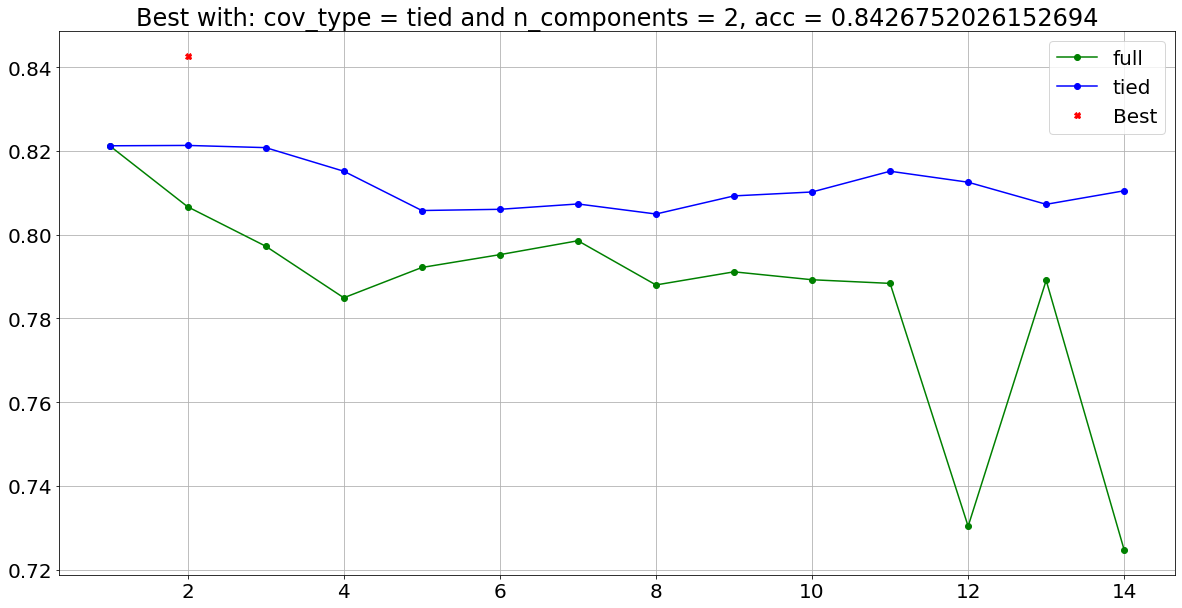

In [ ]:
def make_prediction(gmms,x):
  n_samples =x.shape[0]
  p_test = np.zeros(n_samples)
  for i in range(n_samples):
    pred_val = -np.inf
    for c_idx in range(2):
      dense_val = gmms[c_idx].score(x[i:(i+1)])
      if dense_val > pred_val:
        p_test[i]=c_idx
        pred_val=dense_val
  return p_test

max_iter = 80
componentrange = range(1, 15)
best_cov_type = ''
best_n_component = 0
best_train_acc = 0
cov_types = ['full', 'tied']
colors = ['go-', 'bo-'] 
plt.rcParams['font.size'] = 20
plt.figure(figsize=(20, 10))

for cov_type, color in zip(cov_types, colors):
  train_accs = []
  for n_component in componentrange:
    gmm_models = {0 : GaussianMixture(n_components = n_component, covariance_type = cov_type, max_iter = max_iter),
                  1 : GaussianMixture(n_components = n_component, covariance_type = cov_type, max_iter = max_iter)}

    for (c_idx,model) in gmm_models.items():
      model.fit(x_train[y_train == c_idx])

    train_acc = accuracy_score(y_train, make_prediction(gmm_models, x_train))
    train_accs.append(train_acc)
    print('train_acc with cov_type', cov_type, ', n_components', n_component, ' = ', train_acc)
    if best_train_acc < train_acc:
      best_train_acc = train_acc
      best_cov_type = cov_type
      best_n_component = n_component

  plt.plot(componentrange, train_accs, color, label = cov_type)


gmm_models = {0 : GaussianMixture(n_components = best_n_component, covariance_type = best_cov_type, max_iter = max_iter),
              1 : GaussianMixture(n_components = best_n_component, covariance_type = best_cov_type, max_iter = max_iter)}

for (c_idx ,model) in gmm_models.items():
  model.fit(x_train[y_train==c_idx])

test_acc = accuracy_score(y_test, make_prediction(gmm_models,x_test))
print('The best estimators test accuracy =', test_acc)
plt.plot(best_n_component, test_acc, 'rX', label = 'Best')
plt.title('Best with: cov_type = ' + str(best_cov_type) + ' and n_components = ' + str(best_n_component) + ', acc = ' + str(test_acc))
plt.grid()
_ = plt.legend()


#Tester

In [ ]:
def testModel(estimator, featureVectorCap=None):
  scores=[]
  for i,test in enumerate(tests):
    x,y =getDataForTest(test[0], test[1])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
    if featureVectorCap:
      estimator.fit(x_train[:featureVectorCap],y_train[:featureVectorCap])
    else:
      estimator.fit(x_train,y_train)
    score=estimator.score(x_test,y_test)
    print(score)
    scores.append(score)
  return scores

def testNeuroModel():
  scores=[]
  for i,test in enumerate(tests):
    x,y =getDataForTest(test[0], test[1])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
    y_test_neuro = to_categorical(y_test)
    y_train_neuro = to_categorical(y_train)
    epochs = 50
    batch_size = 256
    num_classes = 2

    model = Sequential()
    model.add(Dense(x_train.shape[1]+1, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(200, kernel_regularizer=keras.regularizers.l2(0.01), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(200, kernel_regularizer=keras.regularizers.l2(0.01), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

    model.fit(x_train, y_train_neuro,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    shuffle=False,
                    validation_split=0.1,
                    callbacks=[early_stopping])
    score = model.evaluate(x_test, y_test_neuro, verbose=0)
    print(str(i+1) + '. test done, score:'+str(score[1]))
    scores.append(score[1])
  return scores

test1 = (['Rainfall', 'MinTemp', 'MaxTemp', 'Humidity3pm','Humidity9am','WindSpeed3pm','WindSpeed9am',
          'Temp9am', 'Temp3pm', 'Pressure3pm','Pressure9am'], False)
test2 = (['Rainfall', 'MinTemp', 'MaxTemp', 'Humidity3pm', 'Humidity9am', 'WindSpeed3pm', 'WindSpeed9am',
          'Temp9am', 'Temp3pm', 'Pressure3pm', 'Pressure9am'],  True)
test3 = (['Rainfall', 'MinTemp', 'MaxTemp', 'Humidity3pm', 'Humidity9am', 'WindSpeed3pm', 'WindSpeed9am',
          'Temp9am', 'Temp3pm', 'Pressure3pm', 'Pressure9am', 'WindGustSpeed', 'Cloud9am', 'Cloud3pm'],True)
test4 = (['Rainfall', 'MinTemp', 'MaxTemp', 'Humidity3pm', 'Humidity9am', 'WindSpeed3pm', 'WindSpeed9am',
          'Temp9am', 'Temp3pm', 'Pressure3pm', 'Pressure9am', 'WindGustSpeed', 'Cloud9am', 'Cloud3pm','Date','Evaporation','Sunshine'],True)
test5 = ([ 'Rainfall', 'Humidity3pm', 'Humidity9am', 'WindSpeed3pm', 'WindSpeed9am', 'Temp9am', 'Temp3pm', 'Pressure3pm',
          'Pressure9am', 'WindGustSpeed', 'Cloud9am', 'Cloud3pm', 'Sunshine'],True)

tests = [test1,test2,test3,test4,test5]

In [ ]:
neuroScores = testNeuroModel()
print(neuroScores)

0. test done, score:0.8516825437545776
1. test done, score:0.856094241142273
2. test done, score:0.8695770502090454
3. test done, score:0.8676192164421082
4. test done, score:0.8721365928649902
[0.8516825437545776, 0.856094241142273, 0.8695770502090454, 0.8676192164421082, 0.8721365928649902]


In [ ]:
model = SVC(C=0.8,kernel='linear',gamma=0.1)
scores = testModel(model,featureVectorCap=20000)
print(scores)

0.8513309188086782
0.8487133984028394
0.8653544915889123
0.8709760716130143
0.8710537276134944
[0.8513309188086782, 0.8487133984028394, 0.8653544915889123, 0.8709760716130143, 0.8710537276134944]


In [ ]:
base_line = DummyClassifier(strategy='most_frequent')
scores = testModel(base_line)
print(scores)

0.798059003481135
0.7961200290392837
0.8024245726350201
0.8028920640385608
0.8018325697625989
[0.798059003481135, 0.7961200290392837, 0.8024245726350201, 0.8028920640385608, 0.8018325697625989]


In [ ]:
model  = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf=3, max_features='auto')
scoresTree = testModel(model)
print(scoresTree)

0.8320616055416857
0.8329031217229975
0.8528910985493428
0.8582372181098296
0.8551436901291128


# Results

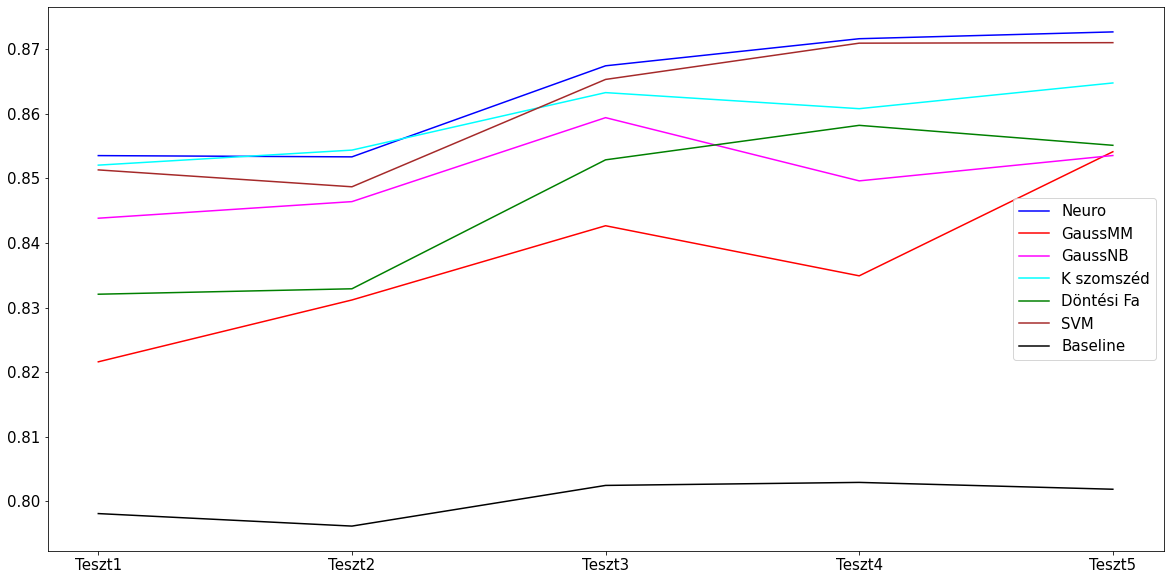

In [ ]:
neuroScores = [0.8535462021827698,0.8533515930175781,0.8674657940864563,0.8716646432876587,0.8727197051048279]
gaussMMScores = [0.8215830373782482, 0.8311688311688312, 0.8426752026152694, 0.8349113444654845, 0.8541441066222407]
gaussNB = [0.8438412039804494, 0.8464144551101073, 0.8594292719471498, 0.8496298846617318, 0.853561016243232]
knnScores = [0.8520693413973769, 0.8544002581269662, 0.8633113124020977, 0.8608194181442589, 0.8648063306955435]
decisionTreeScores=[0.8320616055416857,0.8329031217229975,0.8528910985493428,0.8582372181098296,0.8551436901291128]
svmScores = [0.8513309188086782, 0.8487133984028394, 0.8653544915889123, 0.8709760716130143, 0.8710537276134944]
baseLineScores = [0.798059003481135, 0.7961200290392837, 0.8024245726350201, 0.8028920640385608, 0.8018325697625989]

x = ['Teszt1', 'Teszt2', 'Teszt3', 'Teszt4', 'Teszt5']

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 10))
plt.plot(x,neuroScores,color='blue',label='Neuro')
plt.plot(x,gaussMMScores,color='red',label='GaussMM')
plt.plot(x,gaussNB,color='magenta',label='GaussNB')
plt.plot(x,knnScores,color='cyan',label='K szomszéd')
plt.plot(x,decisionTreeScores,color='green',label='Döntési Fa')
plt.plot(x,svmScores,color='brown',label='SVM')
plt.plot(x,baseLineScores, color='black', label='Baseline')

plt.legend()
plt.show()